In [83]:
import math
import pickle
import os
import pandas as pd
import folium 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from matplotlib import rcParams
from matplotlib.pyplot import *

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

This model predicts confirmed cases of COVID-19 across countries. LSTM is used for prediction.

Code for building LSTM with pytorch is adapted from tuturial https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## Load data

In [2]:
# Reading COVID-19 Raw data
train = pd.read_csv("covid19-global-forecasting-week-3/train.csv")
test = pd.read_csv("covid19-global-forecasting-week-3/test.csv")
submission = pd.read_csv("covid19-global-forecasting-week-3/submission.csv")

In [3]:
train['Date'] = pd.to_datetime(train['Date'])

In [6]:
train.dtypes

Id                         int64
Province_State            object
Country_Region            object
Date              datetime64[ns]
ConfirmedCases           float64
Fatalities               float64
dtype: object

In [7]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


## Preprocessing
calculate confirmed case for each city (mearge states)

In [267]:
# Creating list of all regions/counntries
unique_regions=train['Country_Region'].unique()

In [268]:
countries = train.groupby(['Country_Region', 'Date']).sum()

In [269]:
cases = countries['ConfirmedCases']

In [270]:
cases.head()

Country_Region  Date      
Afghanistan     2020-01-22    0.0
                2020-01-23    0.0
                2020-01-24    0.0
                2020-01-25    0.0
                2020-01-26    0.0
Name: ConfirmedCases, dtype: float64

In [271]:
len(unique_regions)

180

Text(0.5, 1.0, 'confirmed cases for every countries')

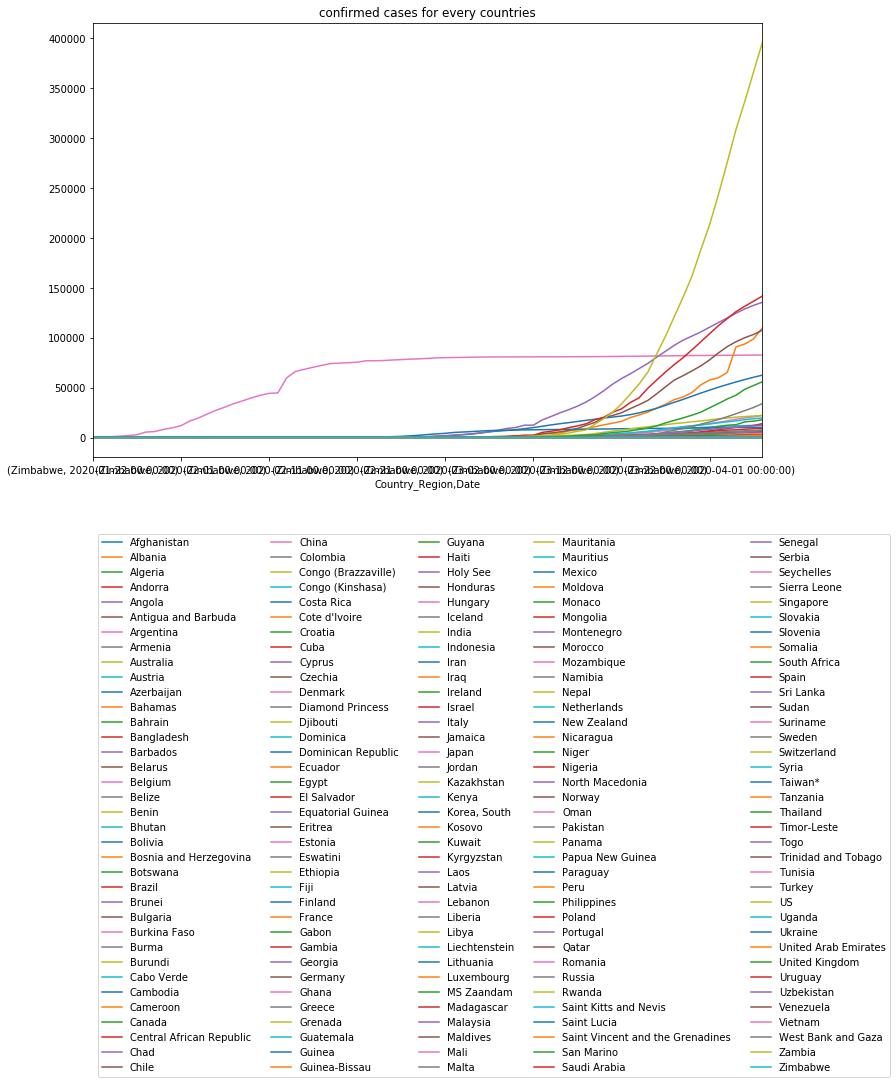

In [272]:
fig, ax = subplots( figsize=(15, 8))
for i in range(180):
    cases.loc[[unique_regions[i]]].plot()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(unique_regions[:180], loc='center left', bbox_to_anchor=(0, -0.8), ncol=5)
ax.set_title("confirmed cases for every countries")

every country starts counting with first comfirmed case

In [306]:
cases_s = cases[cases != 0]

only keep serious countries

In [307]:
maxs = cases.groupby(['Country_Region']).max()
left_regions = maxs[maxs > 5000].index
cases_s = cases_s.iloc[cases_s.index.get_level_values('Country_Region').isin(left_regions) ]
len(left_regions)

27

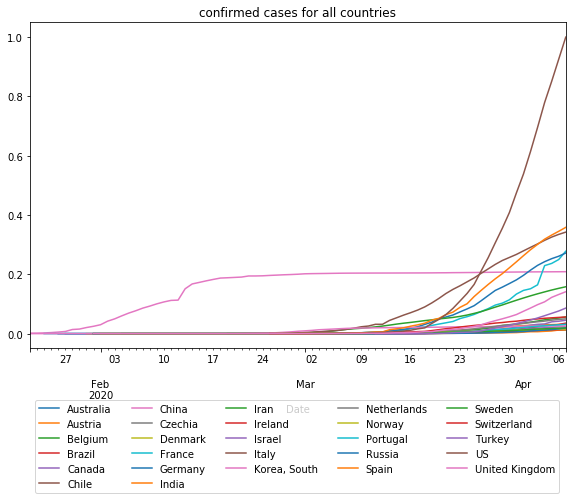

In [421]:
fig, ax = subplots( figsize=(12, 6))
for i in range(len(left_regions)):
    cases_s.loc[left_regions[i]].plot()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(left_regions, loc='center left', bbox_to_anchor=(0, -0.3), ncol=5)
ax.set_title("confirmed cases for all countries")

plt.savefig('fig/data.pdf', bbox_inches='tight')

### devide into training and testing

In [309]:
# scale data
sc = MinMaxScaler()
cases_sc = sc.fit_transform(cases_s.values.reshape(-1, 1))

In [310]:
cases_s[:] = cases_sc.flatten()

In [311]:
# function to segment the training data
def sliding_windows(df, seq_length):
    x = []
    y = []
    y_test = []
    x_test = []
    for i in range(len(df)-seq_length-1):
        if df.index[i+seq_length] < pd.Timestamp('2020-4-1 '):
            _x = df[i:(i+seq_length)]
            _y = df[i+seq_length]
            x.append(_x)
            y.append(_y)
        else:
            _x = df[i:(i+seq_length)]
            _y = df[i+seq_length]
            x_test.append(_x)
            y_test.append(_y)
    return x, y, x_test, y_test

#     return np.array(x),np.array(y), np.array(x_test),np.array(y_test)

In [312]:
seq_length = 7
X_train = []
y_train = []
X_test = []
y_test = []

dataX = []
dataY = []
for i in range(len(left_regions)):
    x_tr, y_tr, x_t, y_t = sliding_windows(cases_s.loc[left_regions[i]], seq_length)
    # put countries together for training
    X_train.extend(x_tr)
    y_train.extend(y_tr)
    X_test.extend(x_t)
    y_test.extend(y_t)
    # separate each county for examination
    dataX.append(torch.Tensor(np.array(x_tr + x_t)).view(-1, seq_length , 1))
    dataY.append(torch.Tensor(np.array(y_tr + y_t)).view(-1,1))
    
    



In [313]:
X_train = torch.Tensor(np.array(X_train))
y_train = torch.Tensor(np.array(y_train))
X_test = torch.Tensor(np.array(X_test))
y_test = torch.Tensor(np.array(y_test))
print('training data: ', X_train.shape, y_train.shape)
print('testing data: ', X_test.shape, y_test.shape)

training data:  torch.Size([1096, 7]) torch.Size([1096])
testing data:  torch.Size([162, 7]) torch.Size([162])


In [314]:
X_train = X_train.view(X_train.shape[0], -1, 1)
y_train = y_train.view(-1,1)
X_test = X_test.view(X_test.shape[0], -1, 1)
y_test = y_test.view(-1,1)

# LSTM Model

In [423]:
class LSTM(nn.Module):

    def __init__(self, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size= 1, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        # a single output prediction
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
#         print(h_out.shape)
        h_out = h_out.view(-1, self.hidden_size)
#         print(h_out.shape)
        out = self.fc(h_out)
        
        return out

## Train

In [384]:

# Train the model
def train(lstm, optimizer, num_epochs, verbose = True):
    for epoch in range(num_epochs):
        outputs = lstm(X_train)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 500 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    print('training loss: {:e}'.format(loss.item()))

# Testing
def test(lstm):
    lstm.eval()
    y_p = lstm(X_test)
    loss = criterion(y_p, y_test)
    print('testing loss: {:e}'.format(loss.item()))



In [411]:
num_epochs = 2000
learning_rate = 0.01

hidden_size = 5
num_layers = 1

lstm = LSTM(hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,  weight_decay = 1e-6)

In [412]:
train(lstm, optimizer, num_epochs)
test(lstm)

Epoch: 0, loss: 0.21878
Epoch: 500, loss: 0.00008
Epoch: 1000, loss: 0.00005
Epoch: 1500, loss: 0.00002
training loss: 5.915982e-06
testing loss: 4.683303e-04


# Plotting results

In [413]:
# calculate predicitions
ys = []
yps = []
lstm.eval()
for i in range(len(left_regions)):
    X, y = dataX[i], dataY[i]
    # predict
    y_p = lstm(X)
    
    # data for plot
    y_p = y_p.data.numpy()
    y = y.data.numpy()
    y_p = sc.inverse_transform(y_p)
    y = sc.inverse_transform(y)
    ys.append(y)
    yps.append(y_p)


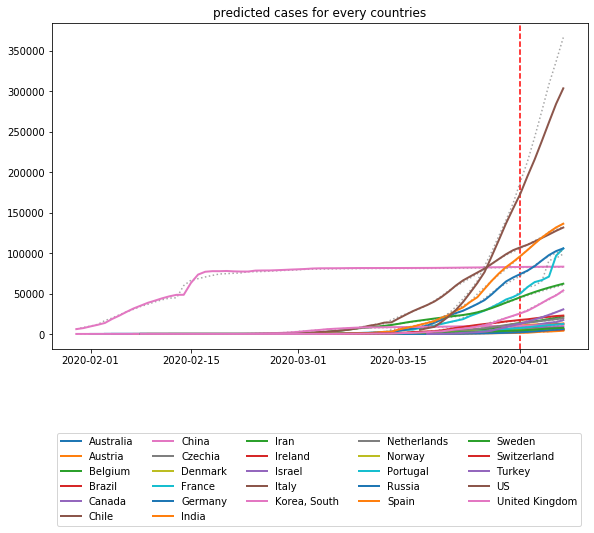

In [422]:
fig, ax = subplots( figsize=(12, 6))
plt.axvline(x=pd.Timestamp('2020-4-1 '), c='r', linestyle='--')
for i in range(len(left_regions)):
    y, y_p = ys[i], yps[i]
    dates = cases_s.loc[left_regions[i]].index[seq_length+1:]    
    #plot
    ax.plot(dates,y,c= 'grey', ls = ':', alpha = 0.7)
    ax.plot(dates,y_p, linewidth=2, label = left_regions[i] )
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the bottom of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0, -0.4), ncol=5)
ax.set_title("predicted cases for every countries")
plt.savefig('fig/predicted.pdf', bbox_inches='tight')
plt.show()

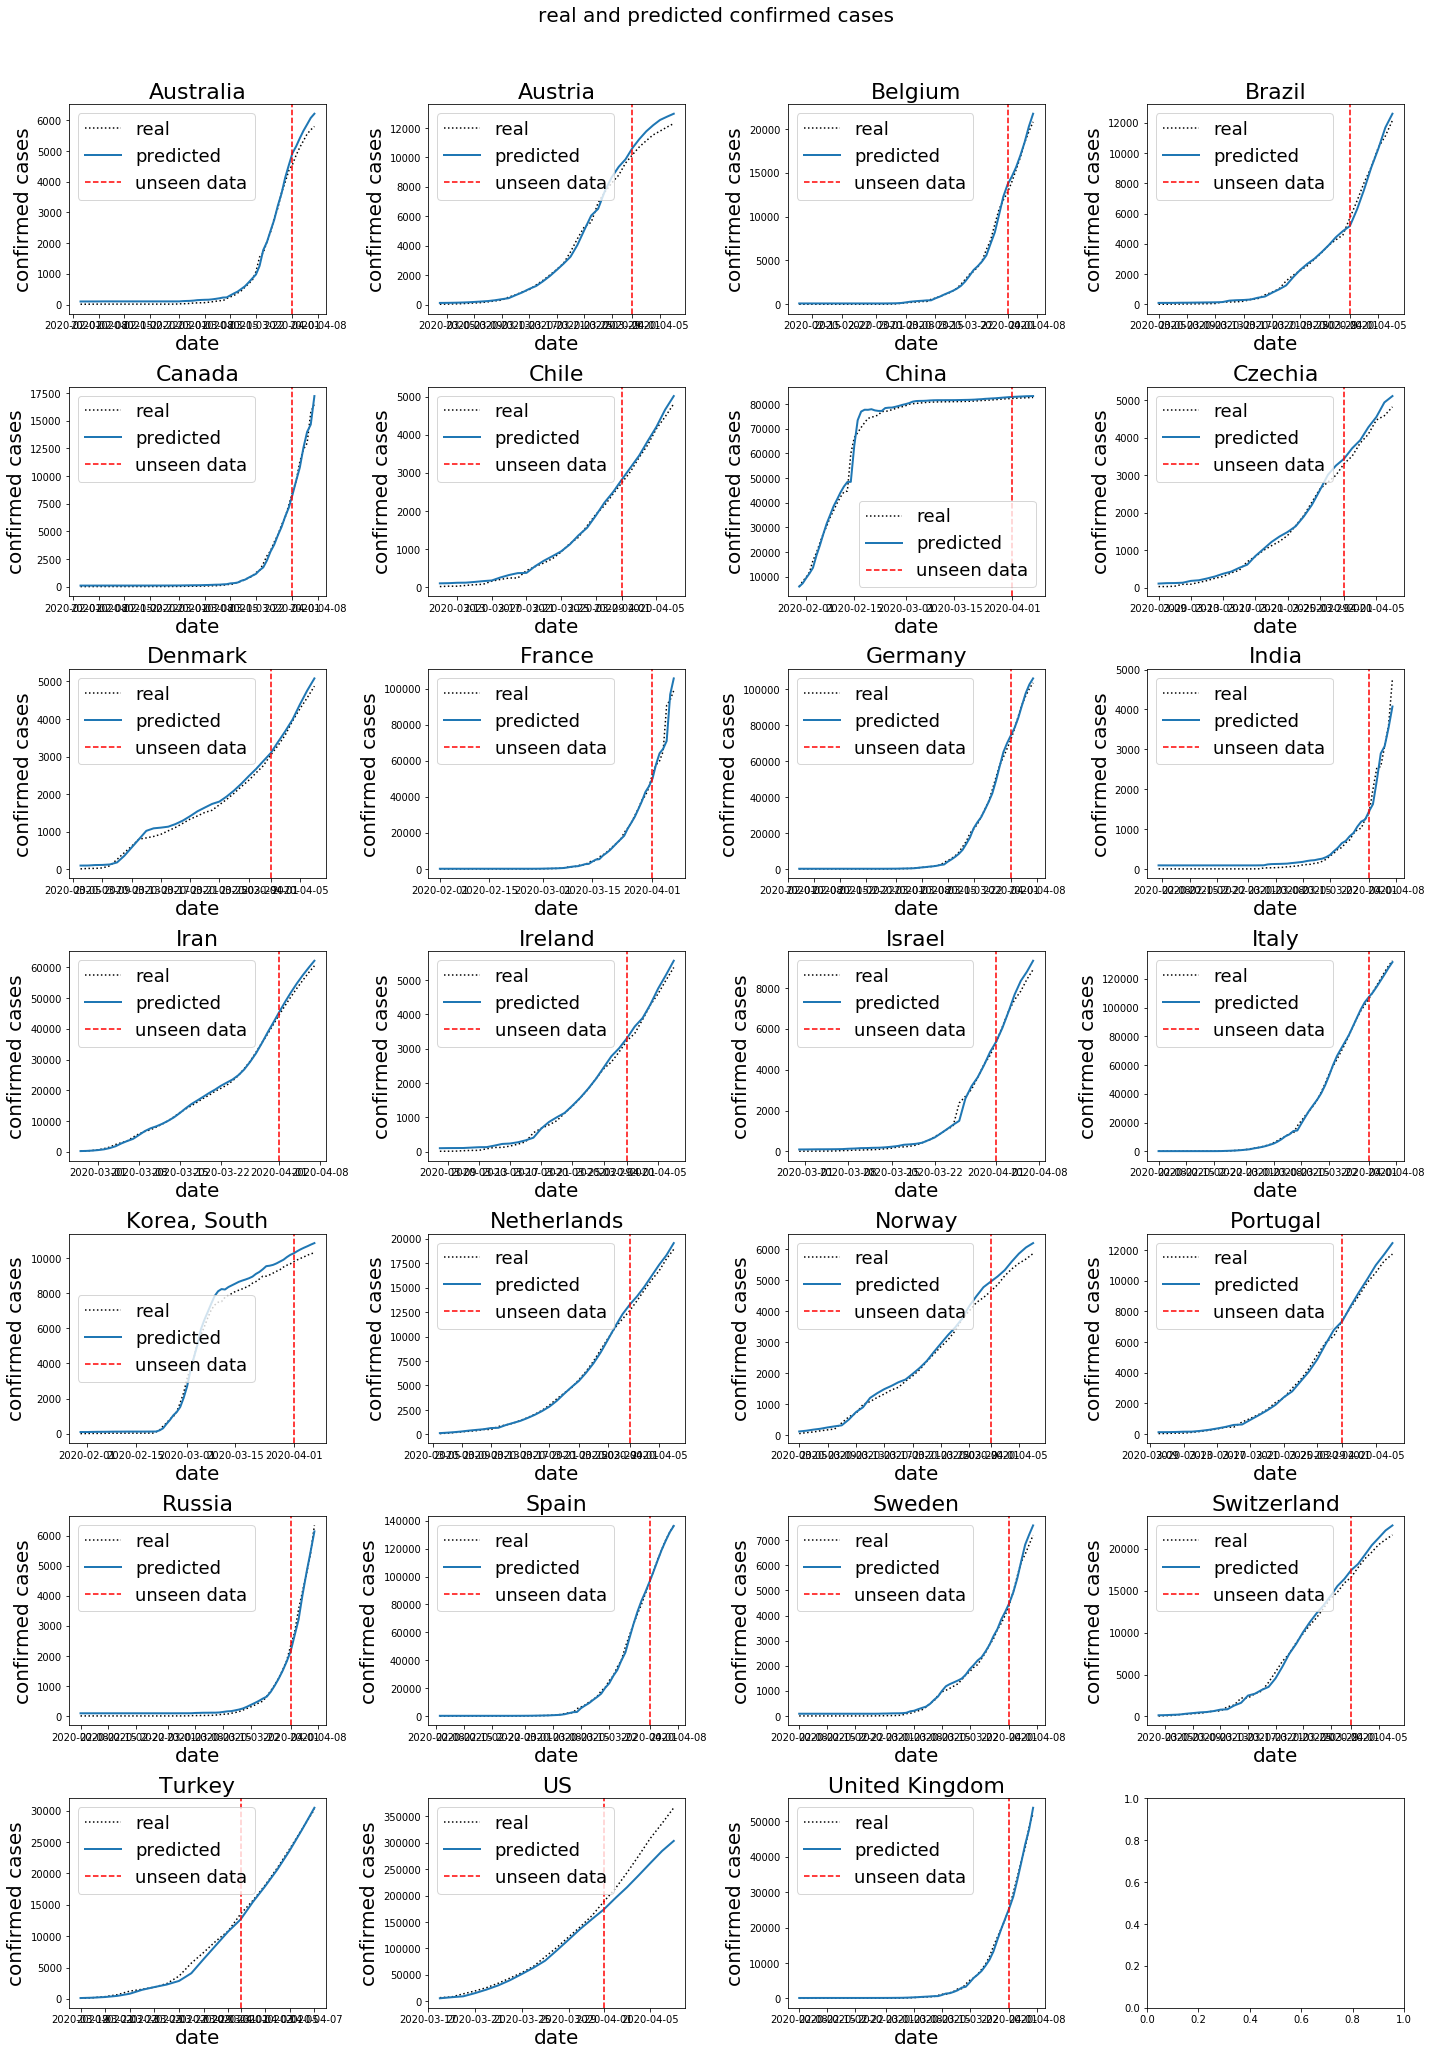

In [419]:
fig, axs = plt.subplots(7,4, figsize=(20, 30))
axs = axs.ravel()
fig.suptitle("real and predicted confirmed cases", fontsize = 20)
for i in range(len(left_regions)):
    y, y_p = ys[i], yps[i]
    dates = cases_s.loc[left_regions[i]].index[seq_length+1:]    
    #plot
    axs[i].plot(dates,y,c= 'k', ls = ':', label = 'real')
    axs[i].plot(dates,y_p, linewidth=2, label = 'predicted')
    axs[i].axvline(x=pd.Timestamp('2020-4-1 '), c='r', linestyle='--', label = 'unseen data')
    
    axs[i].set_title(left_regions[i], fontsize = 22)
    axs[i].set_xlabel("date", fontsize = 20)
    axs[i].set_ylabel('confirmed cases', fontsize = 20)
    axs[i].legend( fontsize = 18)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('fig/predicted_each.pdf', bbox_inches='tight')

## Impact of architecture
Investigate the influence of LSTM hidden size and number of layers

In [393]:
for hidden_size in [2, 5, 10]:
    num_layers = 1
    num_epochs = 2000
    print('hidden size for LSTM: ', hid)
    lstm = LSTM(hidden_size, num_layers)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    train(lstm, optimizer, num_epochs, verbose=False)
    test(lstm)
    print('------------------')

hidden size for LSTM:  2
training loss: 1.141578e-05
testing loss: 8.869912e-04
------------------
hidden size for LSTM:  5
training loss: 3.575298e-06
testing loss: 2.995182e-05
------------------
hidden size for LSTM:  10
training loss: 3.603011e-06
testing loss: 3.174603e-05
------------------


WE can see that as size of hidden layer go up, error first goes down then up. Best size is 5.

## Impact of hyperparameters
Investigate impact of optimization learning rate


In [398]:
for step_size in [0.001, 0.005, 0.01]:
    print('learning rate: ', step_size)
    hidden_size = 5
    num_layers = 1
    lstm = LSTM(hidden_size, num_layers)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=step_size)
    train(lstm, optimizer, num_epochs, verbose=False)
    test(lstm)
    print('------------------')

learning rate:  0.001
training loss: 1.107143e-04
testing loss: 1.816602e-03
------------------
learning rate:  0.005
training loss: 3.497536e-05
testing loss: 1.970778e-03
------------------
learning rate:  0.01
training loss: 4.879545e-06
testing loss: 3.825084e-05
------------------


We can see that learning rate 0.01 is best for our LSTM model

## Impact of regularization
Here we check the influence of l2 regularization

In [404]:
for l2 in [1e-8, 1e-6, 1e-4]:
    print('l2 norm regularization: ', l2)
    hidden_size = 5
    num_layers = 1
    lstm = LSTM(hidden_size, num_layers)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=step_size, weight_decay = l2)
    train(lstm, optimizer, num_epochs, verbose=False)
    test(lstm)
    print('------------------')

l2 norm regularization:  1e-08
training loss: 3.846330e-06
testing loss: 7.029613e-05
------------------
l2 norm regularization:  1e-06
training loss: 4.032986e-06
testing loss: 6.478220e-05
------------------
l2 norm regularization:  0.0001
training loss: 7.353704e-05
testing loss: 2.067197e-03
------------------


We can see that a moderate l2 normolization (1e-6) is helping in this case.

## Impact of optimization methods
Here we compare ADAM with Gradient descent

In [400]:

print('learning rate: ', step_size)
hidden_size = 5
num_layers = 1
learning_rate = 0.01
lstm = LSTM(hidden_size, num_layers)
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(lstm.parameters(), lr=step_size)
train(lstm, optimizer, num_epochs, verbose=False)
test(lstm)

learning rate:  0.01
training loss: 3.156327e-03
testing loss: 3.078640e-02


We can see that Adam performs much better than Gradient descent